In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import roc_curve, auc
import os

In [4]:
df_SV = pd.read_excel('501_trab_continues_time_event_Jan2025v2.xlsx',  sheet_name='Sheet1')

#df_cohort = pd.read_excel('primary_trab_2015.xlsx',  sheet_name='Sheet1')
df_SV["ohsu_mrn"]=df_SV["ohsu_mrn"].astype(str).str.zfill(8)
df_SV.describe()

,IOP_cleaned,age,Alpha_Agonist,Beta_Blockers,Prostaglandin,ACE INHIBITORS,CAI,CAI_PO,DIURETIC,1yrs_failure_highIOP,...,event,time_days,severe_glaucoma,LTG,other_glaucoma,Count_Meds_NoAA,Alpha_Agonist_Count_Meds_NoAA_Interaction,Alpha_Agonist_age_Interaction,Alpha_Agonist_N_Meds_Interaction,Alpha_Agonist_Beta_Blockers_Interaction
count,5.010000e+02,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,...,501.000000,501.00000,501.000000,501.000000,501.000000,5.010000e+02,501.000000,501.000000,501.000000,501.000000
mean,1.329608e-17,0.000000,0.485030,0.728543,0.780439,0.191617,0.634731,0.123752,0.267465,0.083832,...,0.083832,263.98004,0.489022,0.099800,0.411178,2.925139e-17,0.138122,-0.029591,0.321867,0.403194
std,1.001000e+00,1.001000,0.500275,0.445156,0.414363,0.393966,0.481987,0.329628,0.443079,0.277413,...,0.277413,95.80791,0.500379,0.300033,0.492539,1.001000e+00,0.541877,0.763159,0.532360,0.491029
min,-1.843574e+00,-4.995168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,60.00000,0.000000,0.000000,0.000000,-2.333863e+00,-2.333863,-4.567024,-1.420851,0.000000
25%,-6.653235e-01,-0.440608,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,197.00000,0.000000,0.000000,0.000000,-2.021121e-01,0.000000,0.000000,0.000000,0.000000
50%,-3.118484e-01,0.105643,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,298.00000,0.000000,0.000000,0.000000,-2.021121e-01,0.000000,0.000000,0.000000,0.000000
75%,5.129270e-01,0.637132,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,344.00000,1.000000,0.000000,1.000000,8.637633e-01,0.863763,0.009680,1.124487,1.000000
max,5.815055e+00,2.054434,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,365.00000,1.000000,1.000000,1.000000,8.637633e-01,0.863763,2.054434,1.124487,1.000000


## Distribution of Patients by Alpha Agonist Use and Number of Other Medications

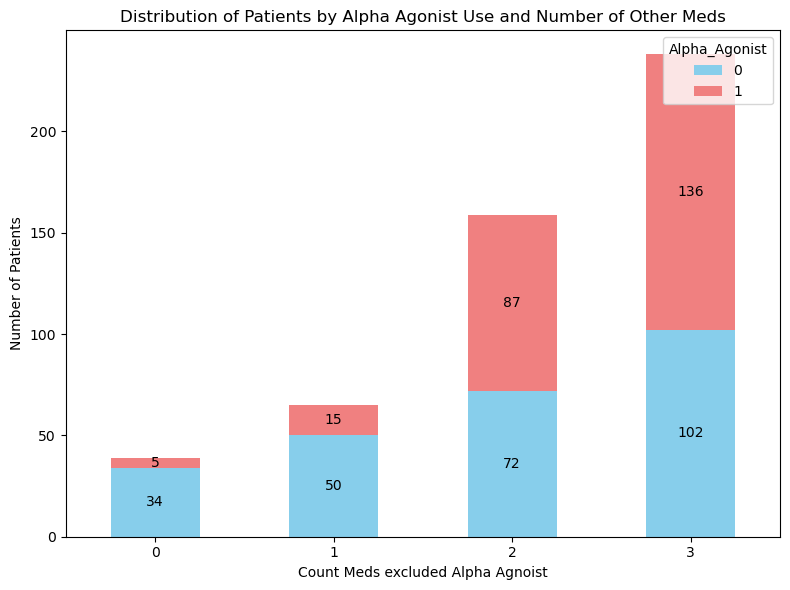

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_SV['Count_Meds_3Meds'] = df_SV['Beta_Blockers']+df_SV['Prostaglandin']+df_SV['CAI_both']
# Calculate the count of Alpha_Agonist = 1 and 0 for each Count_Meds
#grouped = df_lg.groupby('Count_Meds')['Alpha_Agonist'].value_counts().unstack(fill_value=0)
#grouped = df_lg[df_lg['Alpha_Agonist']==0].groupby('Count_Meds')['Count_Meds_NoAA'].value_counts().unstack(fill_value=0)
grouped = df_SV.groupby('Count_Meds_3Meds')['Alpha_Agonist'].value_counts().unstack(fill_value=0)

# Plot the bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'lightcoral'])

# Add the count labels on the bars
for bar_group in ax.containers:
    ax.bar_label(bar_group, label_type='center', fmt='%.0f')  # Display count values

# Set chart title and labels
plt.title('Distribution of Patients by Alpha Agonist Use and Number of Other Meds')
plt.xlabel('Count Meds excluded Alpha Agnoist')
plt.ylabel('Number of Patients')
plt.legend(title='Alpha_Agonist', labels=['0', '1'], loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# Check Collinearity

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select the variables of interest
X = df_SV[["IOP_cleaned", "Count_Meds_NoAA", "Alpha_Agonist", 'age', 'race_White', 'gender_M1_F0']].copy()

# Add a constant (intercept) for the VIF calculation
X = sm.add_constant(X, prepend=True)

# Compute VIF for each feature
vif_data = []
for i in range(X.shape[1]):
    # skip the intercept in interpretation, but we can still see its VIF
    vif = variance_inflation_factor(X.values, i)
    vif_data.append((X.columns[i], vif))

vif_df = pd.DataFrame(vif_data, columns=["Variable", "VIF"])
print("Variance Inflation Factors:")
vif_df

Variance Inflation Factors:


,Variable,VIF
0,const,10.018215
1,IOP_cleaned,1.051074
2,Count_Meds_NoAA,1.107244
3,Alpha_Agonist,1.127232
4,age,1.062514
5,race_White,1.078382
6,gender_M1_F0,1.049861


In [19]:
from lifelines import CoxPHFitter


# Fit the Cox proportional hazards model 
cox = CoxPHFitter()
cox.fit(df_SV, duration_col='time_days', event_col='event', 
        formula="Alpha_Agonist + age + gender_M1_F0 + IOP_cleaned +  race_White + Count_Meds_NoAA  + severe_glaucoma + LTG " )
        
# Print summary of the Cox model
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 501 total observations, 459 right-censored observations>
             duration col = 'time_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 501
number of events observed = 42
   partial log-likelihood = -217.74
         time fit was run = 2025-01-22 22:14:54 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
Alpha_Agonist    1.09      2.98      0.38            0.35            1.83                1.42                6.25
age             -0.26      0.77      0.13           -0.52            0.01                0.60                1.01
gender_M1_F0     0.61      1.83      0.33           -0.05            1.26                0.95                3.53
IOP_cleaned      0.28      1.32      0.12            0.04            0.52                1.04                1.69
race_White      -0.78      0.46      0.36           -1.48           -0.08                0.23                0.92
Count_Meds_NoAA -0.56      0.57      0.17           -0.90           -0.22                0.41                0.80
severe_glaucoma  0.23      1.25      0.36           -0.47            0.92                0.62                2.51
LTG             -0.00      1.00      0.66           -1.30            1.29                0.27                3.64

                 cmp to     z      p  -log2(p)
covariate                                     
Alpha_Agonist      0.00  2.88 <0.005      7.98
age                0.00 -1.91   0.06      4.14
gender_M1_F0       0.00  1.82   0.07      3.85
IOP_cleaned        0.00  2.27   0.02      5.43
race_White         0.00 -2.20   0.03      5.15
Count_Meds_NoAA    0.00 -3.22 <0.005      9.61
severe_glaucoma    0.00  0.63   0.53      0.93
LTG                0.00 -0.00   1.00      0.01
---
Concordance = 0.74
Partial AIC = 451.47
log-likelihood ratio test = 33.52 on 8 df
-log2(p) of ll-ratio test = 14.30

In [16]:
cox.check_assumptions(df_SV, p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5357)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2677)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1491)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1825)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4009)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9487)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2572)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0793)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7587)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3630)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4199)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6748)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7430)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5823)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0827)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1127)'>]]

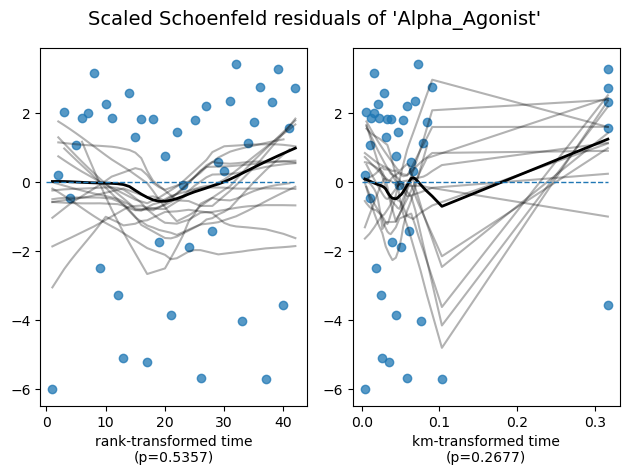

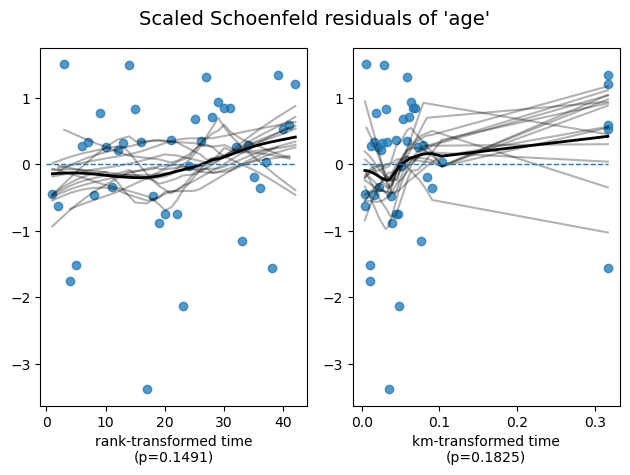

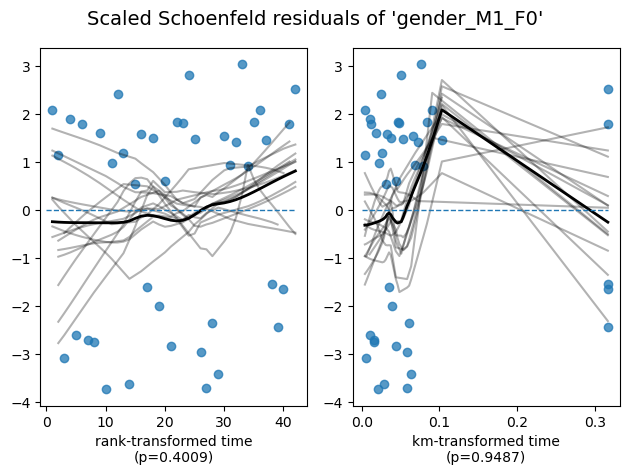

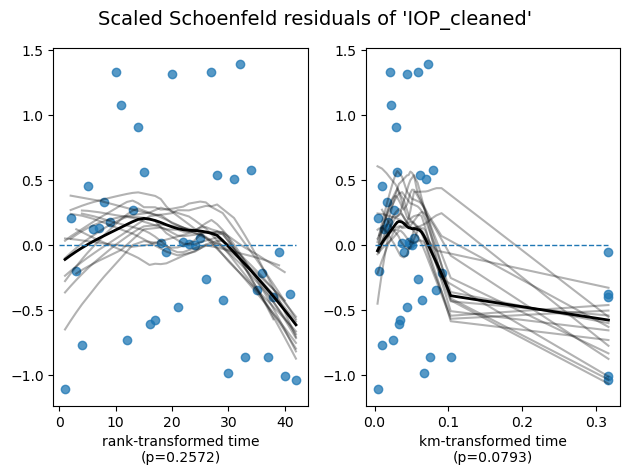

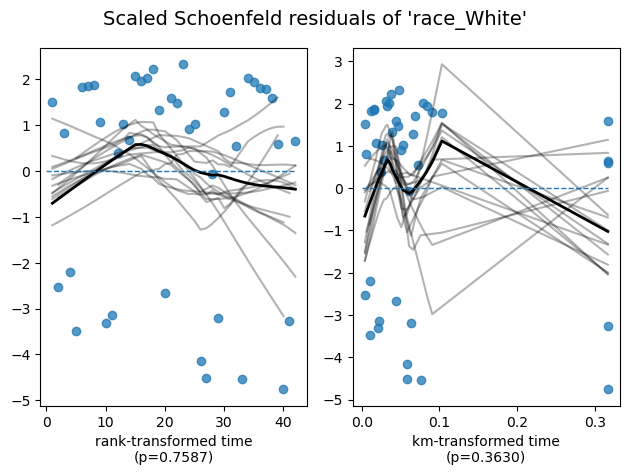

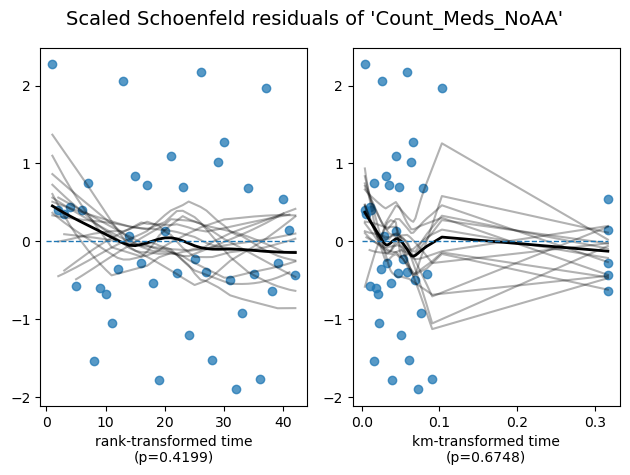

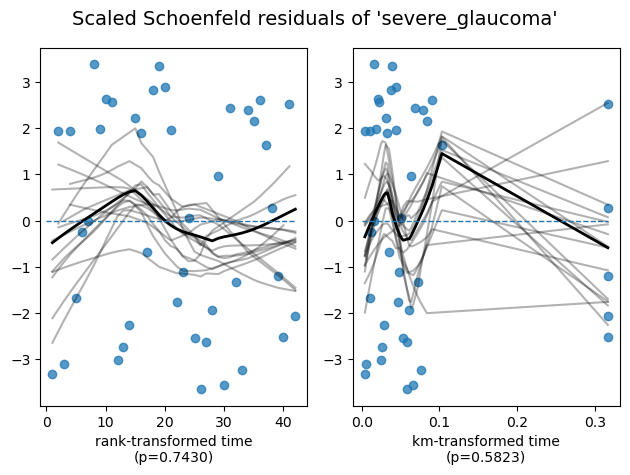

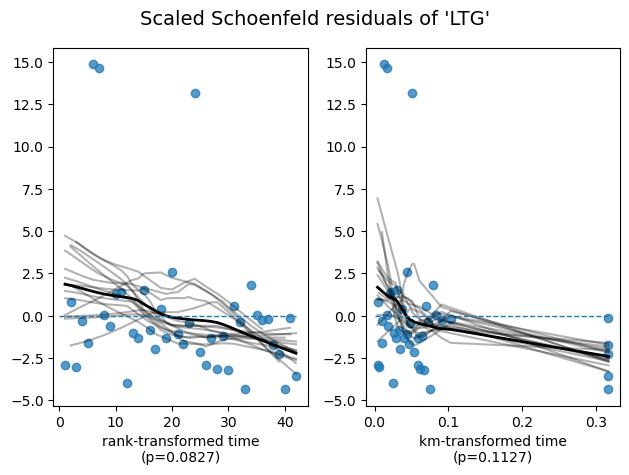

In [20]:
# Check proportional hazards assumption
cox.check_assumptions(df_SV, p_value_threshold=0.05, show_plots=True)

##  Verify Linearity for Continuous Covariates via Residual Plots

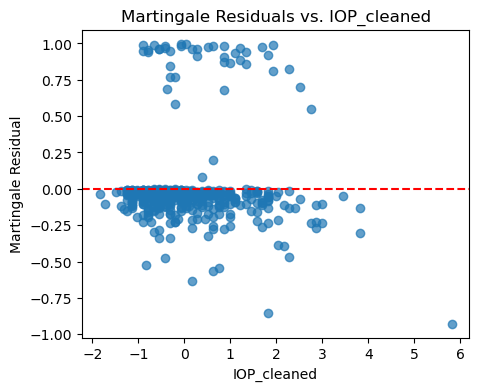

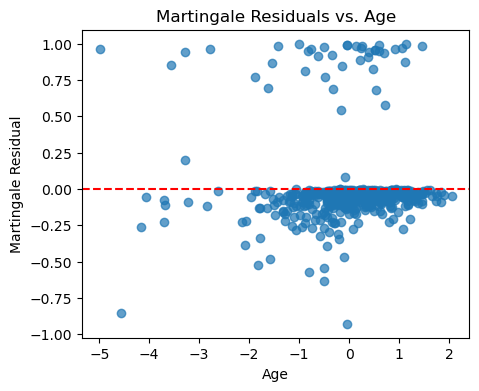

In [22]:
# 1) Compute Martingale residuals
martingale_resids = cox.compute_residuals(df_SV, kind='martingale')

resids_df = pd.DataFrame({
    'martingale': martingale_resids['martingale'],
    'IOP_cleaned': df_SV['IOP_cleaned'],
    'age': df_SV['age']
})

# 2) Plot residuals vs IOP_cleaned
plt.figure(figsize=(5,4))
plt.scatter(resids_df['IOP_cleaned'], resids_df['martingale'], alpha=0.7)
plt.title("Martingale Residuals vs. IOP_cleaned")
plt.xlabel("IOP_cleaned")
plt.ylabel("Martingale Residual")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 3) Plot residuals vs age
plt.figure(figsize=(5,4))
plt.scatter(resids_df['age'], resids_df['martingale'], alpha=0.7)
plt.title("Martingale Residuals vs. Age")
plt.xlabel("Age")
plt.ylabel("Martingale Residual")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


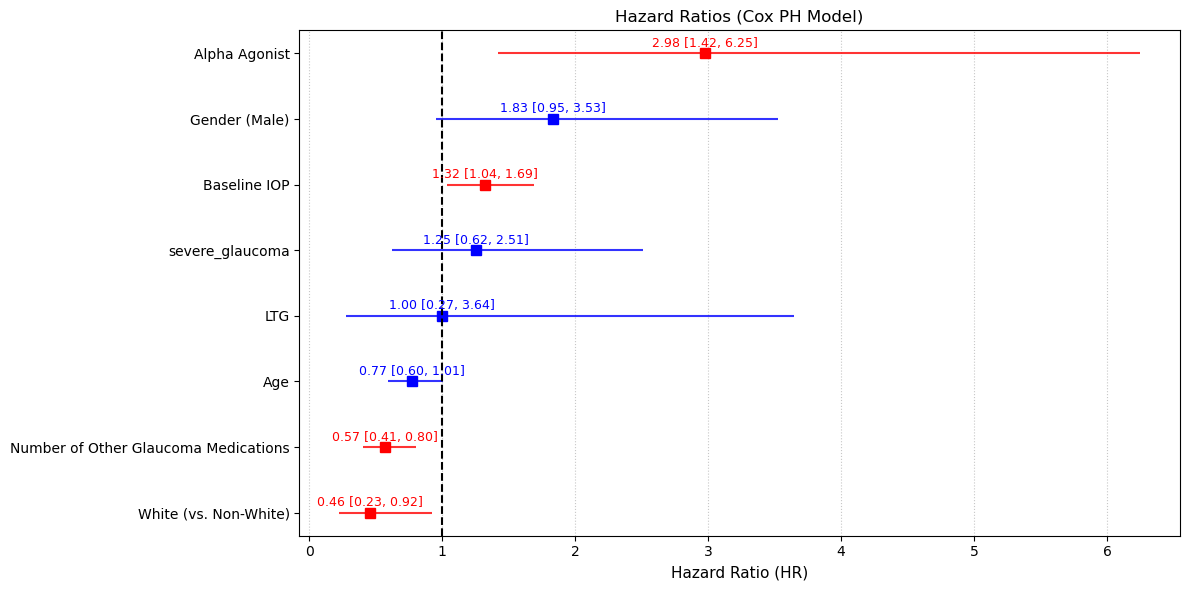

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# and `cox` has already been fitted to your data.
summary = cox.summary

# Extract hazard ratios and confidence intervals
hr = summary['exp(coef)']
hr_lower = summary['exp(coef) lower 95%']
hr_upper = summary['exp(coef) upper 95%']

# Sort variables by hazard ratio (optional)
sorted_idx = hr.sort_values().index
hr = hr.loc[sorted_idx]
hr_lower = hr_lower.loc[sorted_idx]
hr_upper = hr_upper.loc[sorted_idx]

fig, ax = plt.subplots(figsize=(12,6))
y_positions = np.arange(len(hr))

# Significance check
significant = (hr_lower > 1) | (hr_upper < 1)

for i, var in enumerate(hr.index):
    color = 'red' if significant[var] else 'blue'
    ax.plot(hr[var], y_positions[i], 's', color=color, markersize=7)
    ax.hlines(y=y_positions[i], xmin=hr_lower[var], xmax=hr_upper[var], color=color, alpha=0.8)
    ax.text(hr[var], y_positions[i] + 0.1, 
            f"{hr[var]:.2f} [{hr_lower[var]:.2f}, {hr_upper[var]:.2f}]",
            ha='center', fontsize=9, color=color)

# Add a vertical line at HR=1
ax.axvline(1, color='black', linestyle='--')

# Rename variables for more descriptive y-axis labels
rename_map = {
    "Alpha_Agonist": "Alpha Agonist",
    "age": "Age",
    "gender_M1_F0": "Gender (Male)",
    "IOP_cleaned": "Baseline IOP",
    "N_Meds": "Number of Eye Meds",
    "race_White": "White (vs. Non-White)",
    "severe_glaucome": "Severe glaucoma",
    "Count_Meds_NoAA": "Number of Other Glaucoma Medications"
    
}

new_labels = [rename_map.get(var, var) for var in hr.index]

ax.set_yticks(y_positions)
ax.set_yticklabels(new_labels, fontsize=10)

ax.set_xlabel('Hazard Ratio (HR)', fontsize=11)
ax.set_title('Hazard Ratios (Cox PH Model)', fontsize=12)
ax.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

## Check Cox proportional hazards model with Alpha agonist with N meds interaction term

In [12]:
from lifelines import CoxPHFitter

# Fit the Cox proportional hazards model 
cox = CoxPHFitter()
cox.fit(df_SV, duration_col='time_days', event_col='event', 
        formula="Alpha_Agonist + age + gender_M1_F0 + IOP_cleaned +  race_White + Count_Meds_NoAA + Alpha_Agonist_Count_Meds_NoAA_Interaction + severe_glaucoma + LTG " )
        
# Print summary of the Cox model
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 501 total observations, 459 right-censored observations>
             duration col = 'time_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 501
number of events observed = 42
   partial log-likelihood = -217.32
         time fit was run = 2025-01-22 22:11:46 UTC

---
                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                  
Alpha_Agonist                              0.97      2.63      0.38            0.22            1.71                1.25                5.55
age                                       -0.26      0.77      0.13           -0.53            0.00                0.59                1.00
gender_M1_F0                               0.60      1.83      0.33           -0.05            1.26                0.95                3.52
IOP_cleaned                                0.29      1.33      0.12            0.05            0.53                1.05                1.69
race_White                                -0.83      0.44      0.36           -1.54           -0.12                0.21                0.89
Count_Meds_NoAA                           -0.39      0.68      0.25           -0.89            0.11                0.41                1.12
Alpha_Agonist_Count_Meds_NoAA_Interaction -0.30      0.74      0.33           -0.95            0.34                0.39                1.41
severe_glaucoma                            0.23      1.26      0.36           -0.47            0.93                0.63                2.54
LTG                                       -0.04      0.97      0.66           -1.34            1.26                0.26                3.54

                                           cmp to     z    p  -log2(p)
covariate                                                             
Alpha_Agonist                                0.00  2.54 0.01      6.50
age                                          0.00 -1.96 0.05      4.31
gender_M1_F0                                 0.00  1.81 0.07      3.84
IOP_cleaned                                  0.00  2.33 0.02      5.67
race_White                                   0.00 -2.30 0.02      5.53
Count_Meds_NoAA                              0.00 -1.53 0.13      2.99
Alpha_Agonist_Count_Meds_NoAA_Interaction    0.00 -0.92 0.36      1.48
severe_glaucoma                              0.00  0.66 0.51      0.97
LTG                                          0.00 -0.05 0.96      0.06
---
Concordance = 0.74
Partial AIC = 452.64
log-likelihood ratio test = 34.36 on 9 df
-log2(p) of ll-ratio test = 13.66

## Cox proportional hazards model for each glaucoma meds

In [25]:
from lifelines import CoxPHFitter


# Fit the Cox proportional hazards model ACEI+ 
# The formula can be adjusted as needed. Including the key variable Alpha_Agonist and other covariates:
cox2 = CoxPHFitter()
cox2.fit(df_SV, duration_col='time_days', event_col='event', 
        formula="Alpha_Agonist + age + gender_M1_F0 + IOP_cleaned + Prostaglandin + race_White + Beta_Blockers + CAI_both +severe_glaucoma+LTG")
        
# Print summary of the Cox model
cox2.print_summary()

<lifelines.CoxPHFitter: fitted with 501 total observations, 459 right-censored observations>
             duration col = 'time_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 501
number of events observed = 42
   partial log-likelihood = -217.59
         time fit was run = 2025-01-22 22:22:50 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
Alpha_Agonist    1.09      2.99      0.38            0.35            1.84                1.42                6.29
age             -0.25      0.78      0.13           -0.52            0.01                0.60                1.01
gender_M1_F0     0.57      1.77      0.34           -0.09            1.24                0.91                3.45
IOP_cleaned      0.28      1.33      0.13            0.04            0.53                1.04                1.70
Prostaglandin   -0.61      0.55      0.36           -1.31            0.09                0.27                1.10
race_White      -0.80      0.45      0.36           -1.51           -0.10                0.22                0.91
Beta_Blockers   -0.75      0.47      0.38           -1.49           -0.01                0.23                0.99
CAI_both        -0.44      0.64      0.38           -1.18            0.30                0.31                1.35
severe_glaucoma  0.22      1.24      0.36           -0.48            0.92                0.62                2.50
LTG             -0.04      0.96      0.67           -1.35            1.27                0.26                3.56

                 cmp to     z      p  -log2(p)
covariate                                     
Alpha_Agonist      0.00  2.88 <0.005      7.96
age                0.00 -1.89   0.06      4.09
gender_M1_F0       0.00  1.69   0.09      3.46
IOP_cleaned        0.00  2.26   0.02      5.39
Prostaglandin      0.00 -1.70   0.09      3.49
race_White         0.00 -2.23   0.03      5.29
Beta_Blockers      0.00 -1.99   0.05      4.43
CAI_both           0.00 -1.17   0.24      2.04
severe_glaucoma    0.00  0.60   0.55      0.87
LTG                0.00 -0.06   0.96      0.07
---
Concordance = 0.74
Partial AIC = 455.19
log-likelihood ratio test = 33.81 on 10 df
-log2(p) of ll-ratio test = 12.30

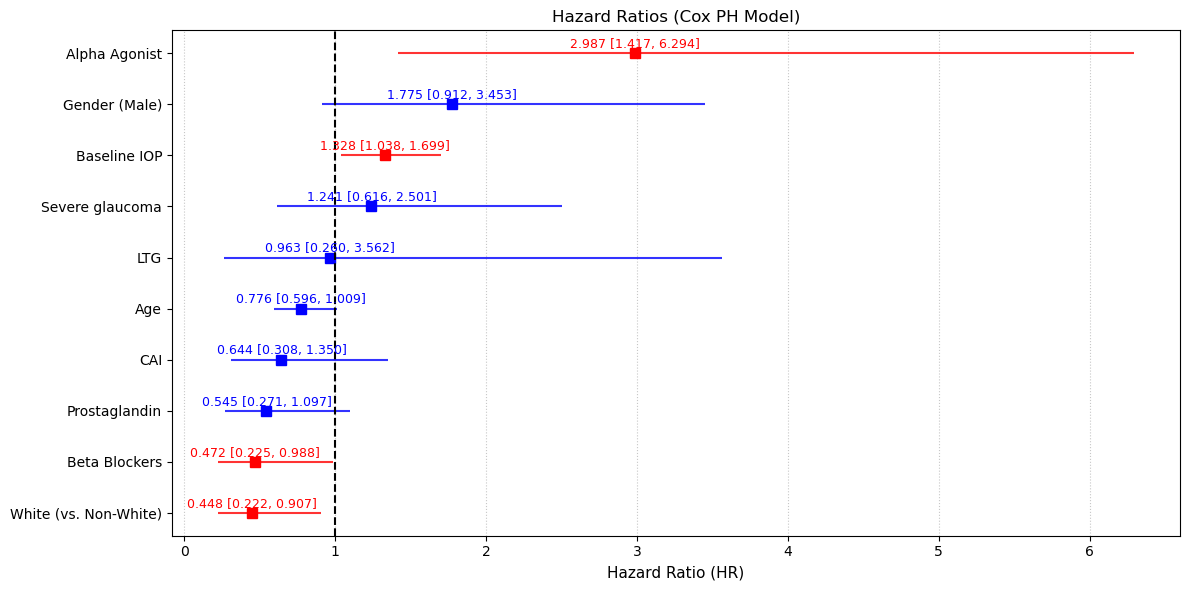

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# and `cox` has already been fitted to your data.
summary = cox2.summary

# Extract hazard ratios and confidence intervals
hr = summary['exp(coef)']
hr_lower = summary['exp(coef) lower 95%']
hr_upper = summary['exp(coef) upper 95%']

# Sort variables by hazard ratio (optional)
sorted_idx = hr.sort_values().index
hr = hr.loc[sorted_idx]
hr_lower = hr_lower.loc[sorted_idx]
hr_upper = hr_upper.loc[sorted_idx]

fig, ax = plt.subplots(figsize=(12,6))
y_positions = np.arange(len(hr))

# Significance check
significant = (hr_lower > 1) | (hr_upper < 1)

for i, var in enumerate(hr.index):
    color = 'red' if significant[var] else 'blue'
    ax.plot(hr[var], y_positions[i], 's', color=color, markersize=7)
    ax.hlines(y=y_positions[i], xmin=hr_lower[var], xmax=hr_upper[var], color=color, alpha=0.8)
    ax.text(hr[var], y_positions[i] + 0.1, 
            f"{hr[var]:.3f} [{hr_lower[var]:.3f}, {hr_upper[var]:.3f}]",
            ha='center', fontsize=9, color=color)

# Add a vertical line at HR=1
ax.axvline(1, color='black', linestyle='--')

# Rename variables for more descriptive y-axis labels
rename_map = {
    "Alpha_Agonist": "Alpha Agonist",
    "age": "Age",
    "gender_M1_F0": "Gender (Male)",
    "IOP_cleaned": "Baseline IOP",
    "N_Meds": "Number of Eye Meds",
    "race_White": "White (vs. Non-White)",
    "severe_glaucoma": "Severe glaucoma",
    "CAI_both": "CAI",
    "Beta_Blockers": "Beta Blockers",
    
}

new_labels = [rename_map.get(var, var) for var in hr.index]

ax.set_yticks(y_positions)
ax.set_yticklabels(new_labels, fontsize=10)

ax.set_xlabel('Hazard Ratio (HR)', fontsize=11)
ax.set_title('Hazard Ratios (Cox PH Model)', fontsize=12)
ax.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.6382)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3025)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1586)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2068)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4509)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7148)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1636)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0568)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1075)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6689)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7587)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4902)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5367)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1043)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8206)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0852)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8691)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6867)'>],
 [<Axes: xlabel='rank-transformed tim

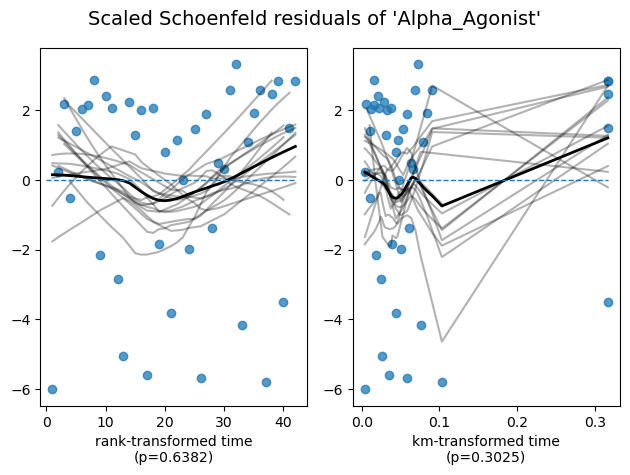

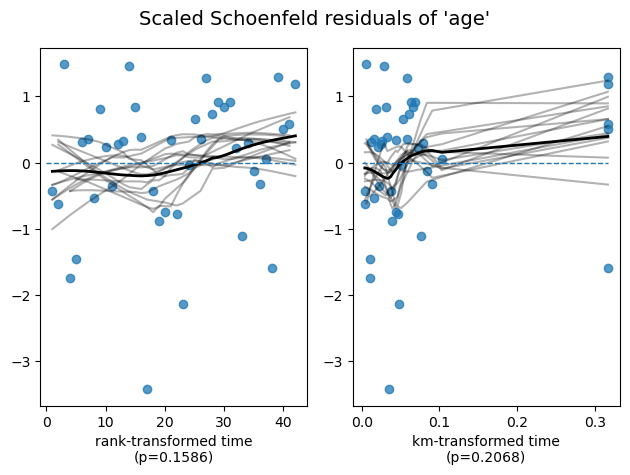

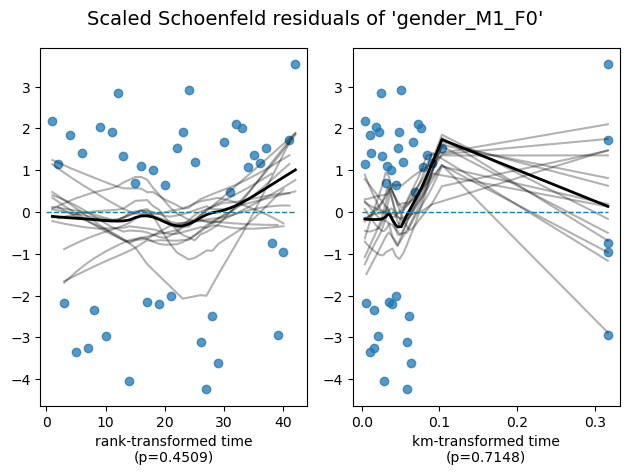

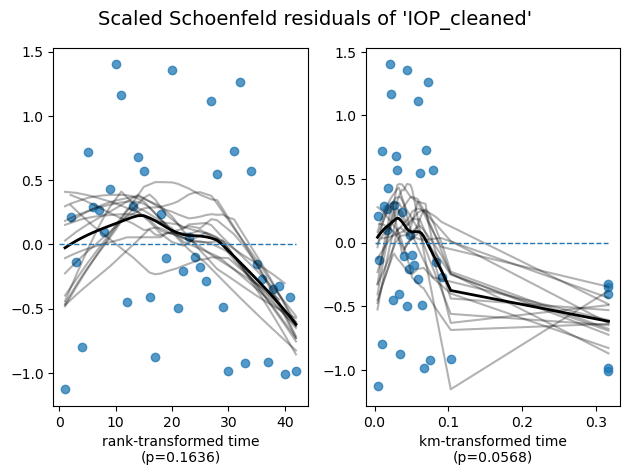

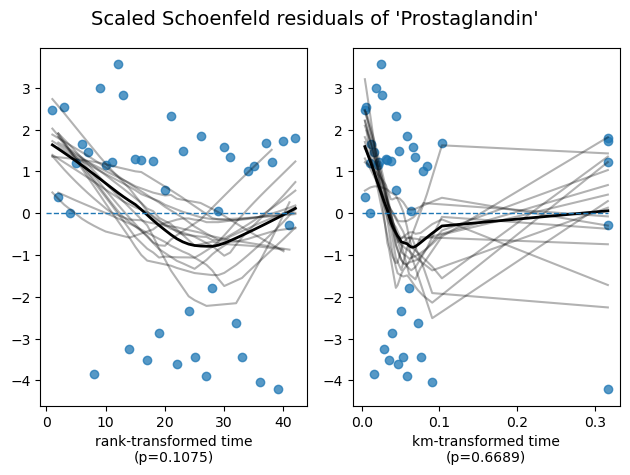

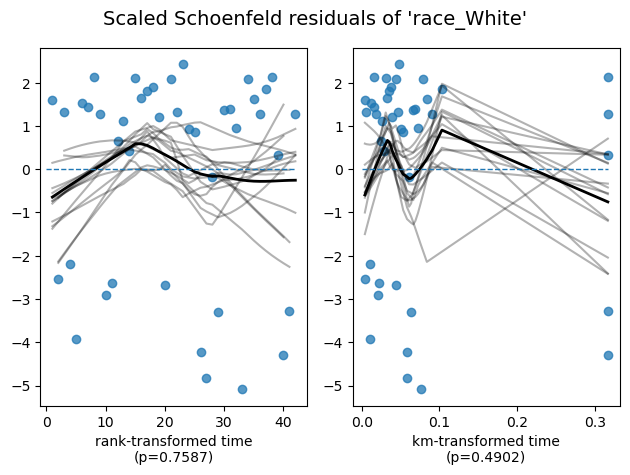

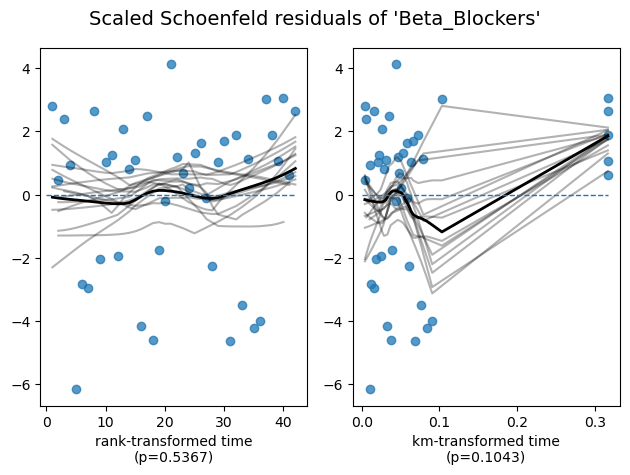

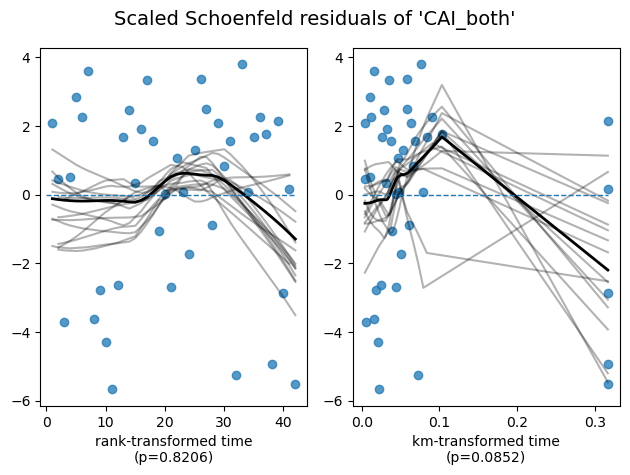

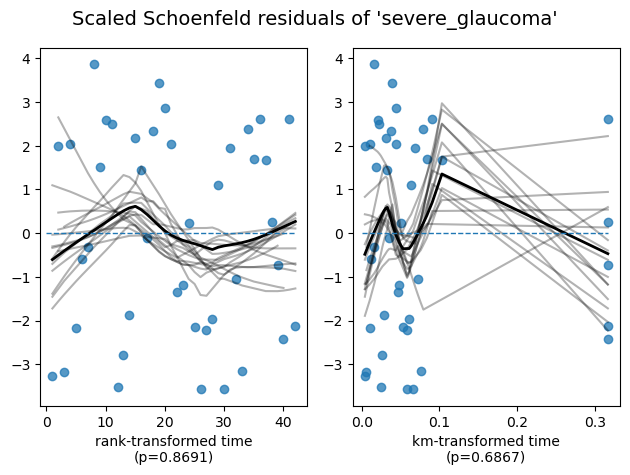

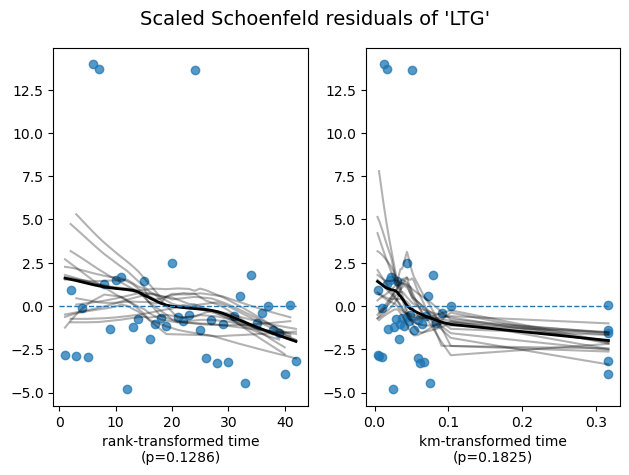

In [31]:
# Check proportional hazards assumption
cox2.check_assumptions(df_SV, p_value_threshold=0.05,show_plots=True)